# Imports and other initializations


In [1]:
# General imports 
import glob
import shutil
import os
import sys
import traceback
from pathlib import Path
import pickle
import random
from enum import Enum
import datetime
from functools import partial
from multiprocess import Pool

from tqdm import tqdm
import easydict

# Interactive multithreading
from nbmultitask import ThreadWithLogAndControls
from time import sleep

# Imports relative to web mapping and displaying results
from ipyleaflet import Map, basemaps, ImageOverlay, TileLayer, GeoData
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from sidecar import Sidecar


# Array processing libraries
import numpy as np
from numpy import unravel_index
import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.io import MemoryFile

# Geospatial data wrangling (mostly vector data)
import utm
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon,MultiPoint

# EO-learn/Sentinelhub imports
from eolearn.core import (
	EOWorkflow,
	Dependency,
	EOPatch,
	LoadFromDisk,
	SaveToDisk,
	OverwritePermission,
	FeatureType,
	LinearWorkflow,
	EOTask)
from eolearn.features import LinearInterpolation, SimpleFilterTask
from eolearn.geometry import PointSamplingTask, VectorToRaster
from eolearn.io import ExportToTiff, SentinelHubWCSInput
from eolearn.mask import AddValidDataMaskTask
from eolearn.ml_tools import MorphologicalOperations, MorphologicalStructFactory
from sentinelhub import CRS, BBoxSplitter, WcsRequest, DataSource

# ML libraries
import lightgbm as lgb
from sklearn import metrics
from sklearn import preprocessing
import joblib
import shap

# If a buffer size is defined around the AOI, it can be passed here in meters
args = easydict.EasyDict({
  "aoi": "./aoi_eochallenge_trimmed.geojson",
  "training_path": ["./training_data/trainingdata_germany_trimmed.shp","./training_data/trainingdata_romania_trimmed.shp"],
  "aoi_bufsize": 10000,
  "zoom_level": (10,10),
  "hour_diff": 73,
  "cloud_threshold": 0.8,
  "maxcc": 0.5,
  "dest": "/mnt/10t-drive/eochallenge",
  "time_range": ["2005-01-01","2016-12-30"],
  "save_choice": True,
  "n_procs": 4,
  "resolution": 23.5,
  "narrow_interpolation": True,
  "proba": True,
  "shap": False,
  "gif": True,
  "interpolation_interval": 30,
  "lulc_classes": {
    "no data": 0,
    "forest": 1,
    "grass": 2,
    "farmland": 3,
    "bare soil": 4,
    "built-up": 5,
    "permanent water": 6,
  }})


/home/sheykhes/Desktop/ml/foss4g/code/foss4g_eochallenge/eoc_py37_env/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Various utilities required by the notebook


In [2]:
class MaxCCPredicate:
    """
    Returns True if the image contains a smaller cloud cover percentage than the specified 'maxcc' value.
    """

    def __init__(self, maxcc):
        self.maxcc = maxcc

    def __call__(self, img_cm):
        w, h, _ = img_cm.shape
        cc = np.sum(img_cm) / (w * h)
        return cc <= self.maxcc


class SentinelHubValidData:
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is assumed to be found in eopatch.mask['CLM']
    """

    def __call__(self, eopatch):
        #disabled the original predicate while we dont have CLM mask
        #return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool),
        #                      np.logical_not(eopatch.mask['CLM'].astype(np.bool)))
        return eopatch.mask['IS_DATA'].astype(np.bool)


class CountValid(EOTask):
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """

    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name

    def execute(self, eopatch):
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.name, np.count_nonzero(eopatch.mask[self.what], axis=0))

        return eopatch


class MakeGif:
    """
    Generates a GIF animation from an EOPatch.
    """

    def __init__(self, size=(640, 480)):
        self.fig = plt.figure()
        self.fig.set_size_inches(size[0] / 100, size[1] / 100)
        ax = self.fig.add_axes([0, 0, 1, 1], frameon=False, aspect=1)
        ax.set_xticks([])
        ax.set_yticks([])
        self.images = []

    def add(self, eopatch, label='', band=1):
        for i in range(len(eopatch)):
            image = eopatch[i]
            if image.shape[2] != 3 or image.shape[2] != 4:
                image = image[..., band - 1]
                plt_im = plt.imshow(image, cmap='Greys', animated=True)
            else:
                plt_im = plt.imshow(image, animated=True)
            plt_txt = plt.text(10, 40, label[i], color='red')
            self.images.append([plt_im, plt_txt])

    def save(self, filename, fps):
        animation = anim.ArtistAnimation(self.fig, self.images)
        animation.save(filename, writer='imagemagick', fps=fps)


class LoadFromMemory(EOTask):
    """
        Task to load EOPatches to the EOWorkflow from memory
    """

    @staticmethod
    def execute(eopatch):
        return eopatch


class ConcatenateData(EOTask):
    """
        Task to concatenate data arrays along the last dimension
    """

    def __init__(self, feature_name, feature_names_to_concatenate):
        self.feature_name = feature_name
        self.feature_names_to_concatenate = feature_names_to_concatenate

    def execute(self, eopatch):
        arrays = [eopatch.data[name] for name in self.feature_names_to_concatenate]

        eopatch.add_feature(FeatureType.DATA, self.feature_name, np.concatenate(arrays, axis=-1))

        return eopatch


class MoveFeature(EOTask):
    """
    Task to copy fields from one eopatch to another
    The fields are defined as a dictionary in the form {FeatureType: {feature_names_to_copy}}
    """

    def __init__(self, fields_to_copy):
        self.fields_to_copy = fields_to_copy

    def execute(self, *eopatches):

        dst_eopatch, src_eopatch = eopatches
        for key in self.fields_to_copy.keys():
            for name in self.fields_to_copy[key]:
                dst_eopatch.add_feature(key, name, src_eopatch[key][name])
        return dst_eopatch


class ClassFilterTask(EOTask):
    """
    Run class specific morphological operation.
    """

    def __init__(self, lulc_feature, lulc_values, morph_operation, struct_elem=None):
        self.lulc_feature_type, self.lulc_feature_name = next(iter(self._parse_features(lulc_feature)))
        self.lulc_values = lulc_values

        if isinstance(morph_operation, MorphologicalOperations):
            self.morph_operation = MorphologicalOperations.get_operation(morph_operation)
        else:
            self.morph_operation = morph_operation
        self.struct_elem = struct_elem

    def execute(self, eopatch):
        lulc = eopatch[self.lulc_feature_type][self.lulc_feature_name].copy()

        for lulc_value in self.lulc_values:
            lulc_mod = self.morph_operation((lulc == lulc_value).squeeze(), self.struct_elem) * lulc_value
            lulc_mod = lulc_mod[..., np.newaxis]
            lulc[lulc == lulc_value] = lulc_mod[lulc == lulc_value]

        eopatch.add_feature(self.lulc_feature_type, self.lulc_feature_name, lulc)

        return eopatch


def recompute_interpolation_range(range_idx, out_path=None, n_samples=1000, **kwargs):
    """
    Recompute the "start_date" and "end_date" of a time range based on a set of EOPatches
    """

    if out_path is None:
        out_path = '/'.join([str(arg) for arg in kwargs.values()])

    # load sampled eopatches
    eopatches = []
    eopatches_sample = []
    for idx in range_idx:
        if os.path.isfile(f'{out_path}/lulc_sample/eopatch_{idx}/data/BANDS.npy') \
                or os.path.isfile(f'{out_path}/lulc_nosample/eopatch_{idx}/data/BANDS.npy'):
            try:
                eopatches.append(EOPatch.load(f'{out_path}/lulc_sample/eopatch_{idx}', lazy_loading=True))
                eopatches_sample.append(EOPatch.load(f'{out_path}/lulc_sample/eopatch_{idx}', lazy_loading=True))
            except:
                eopatches.append(EOPatch.load(f'{out_path}/lulc_nosample/eopatch_{idx}', lazy_loading=True))
        else:
            continue

    eopatches = np.asarray(eopatches)

    if n_samples is None:
        n_samples = np.amin([np.count_nonzero(eopatch.mask_timeless['LULC']) for eopatch in eopatches_sample])

    print(f'n_samples:{n_samples}')

    start_date = np.amax([eopatch.timestamp[0] for eopatch in eopatches]).strftime("%Y-%m-%d")
    end_date = np.amin([eopatch.timestamp[-1] for eopatch in eopatches]).strftime("%Y-%m-%d")

    print(f'start date of interpolation range:{start_date}')
    print(f'end date of interpolation range:{end_date}')

    return start_date, end_date


def clean_training_data(range_sample, out_path=None, **kwargs):
    """
    Performs cleaning on the EOPatches which contain training data.
    The types of errors it corrects are the following:
    - Training data polygon slivers inside the EOPatch which, when rasterized, return 0 training pixels.
    - Erroneous training data vector geometries

    Parameters
    ------------
    range_sample: list of integer
       A list of EOPatch indices indicating the EOPatches that contain training data
    out_path: str
        Path where to save generated outputs
    **kwargs: dict
        Other arguments which may be specified to create a custom output path to store outputs

    Returns
    ------------
    eopatches: list of EOPatch Object
        Lazily loaded list of EOPatches
    range_sample_clean: list of integer
        Cleaned-up list of EOPatch indices
    """

    if out_path is None:
        out_path = '/'.join([str(arg) for arg in kwargs.values()])

    eopatches = []
    range_sample_clean = []
    for idx in range_sample:
        if os.path.isdir(f'{out_path}/lulc_sampled/eopatch_{idx}'):
            eopatch = EOPatch.load(f'{out_path}/lulc_sampled/eopatch_{idx}', lazy_loading=True)
        else:
            continue
        try:
            if eopatch.mask_timeless['LULC_SAMPLED'].shape[0] == 0:
                print(f'patch {idx} removed from samples due to insufficient amount of samples, removing it...')
                eopatch.remove_feature(FeatureType.MASK_TIMELESS, 'LULC_SAMPLED', )
                eopatch.remove_feature(FeatureType.DATA_TIMELESS, 'SPLIT_SAMPLED', )
            else:
                print(f'patch {idx} kept in sample')
                range_sample_clean.append(idx)
                eopatches.append(eopatch)
        except:
            print(f'patch {idx} removed from samples due to unknown defect...')

    return eopatches, range_sample_clean

def _craft_input_features(eopatches, range_sample, lulc_classes, out_path=None, **kwargs):
    """
    Prepare the numpy arrays input features necessary to train and test the Random Forest model

    Parameters
    ------------
    range_sample: list of integer
       A list of EOPatches indices indicating the EOPatches that contain training data
    class_labels: list of integer
       List of integers indicating the land cover classes to be classified
    class_names: list of string
        List of strings (land cover class names) indicating the land cover classes to be classified
    out_path: str
        Path where to save generated outputs
    **kwargs: dict
        Other arguments which may be specified to create a custom output path to store outputs

    Returns
    ------------
    features_train: numpy array
        Numpy array containing input features to train on
    features_test: numpy array
        Numpy array containing input features to test on
    labels_train: numpy array
        Numpy array containing input labels to train on
    labels_test: numpy array
        Numpy array containing input labels to test on
    labels_unique: list of integer
        List of integers identifying the labels which are effectively present in the training dataset
        (i.e. some classes maybe missing from the full land cover class nomenclature)
    """

    if out_path is None:
        out_path = '/'.join([str(arg) for arg in kwargs.values()])

    if not os.path.isdir(f'{out_path}/validation'):
        os.makedirs(f'{out_path}/validation', exist_ok=True)
    joblib.dump(range_sample, f'{out_path}/validation/range_sample.pkl')
    random.shuffle(range_sample)

    split = np.stack([eopatch.data_timeless['SPLIT_SAMPLED'] for eopatch in eopatches])
    labels = np.stack([eopatch.mask_timeless['LULC_SAMPLED'] for eopatch in eopatches])

    labels_train = np.where(split == 1, labels, 0)
    labels_test = np.where(split == 2, labels, 0)

    features = np.stack([eopatch.data['FEATURES_SAMPLED'] for eopatch in eopatches])
    features_reshape = np.tile(split, (features.shape[1], 1, 1, features.shape[4]))
    features = np.concatenate(features)
    features_train = np.where(features_reshape == 1, features, 0).reshape(len(range_sample),
                                                                          int(features.shape[0] / len(range_sample)),
                                                                          features.shape[1], features.shape[2],
                                                                          features.shape[3])
    features_test = np.where(features_reshape == 2, features, 0).reshape(len(range_sample),
                                                                         int(features.shape[0] / len(range_sample)),
                                                                         features.shape[1], features.shape[2],
                                                                         features.shape[3])

    print(np.count_nonzero(labels))
    print(np.count_nonzero(split))
    print(np.unique(labels_train))
    print(np.unique(labels_test))

    # rotate dimension so that reshape can be used
    p1, t1, w1, h1, f1 = features_train.shape
    p2, t2, w2, h2, f2 = features_test.shape

    # reshape to n x m
    features_train = np.swapaxes(features_train, 1, 3).reshape(p1 * h1 * w1, t1 * f1)
    labels_train = np.swapaxes(labels_train, 1, 2).reshape(p1 * h1 * w1, 1).squeeze()
    features_test = np.swapaxes(features_test, 1, 3).reshape(p2 * h2 * w2, t2 * f2)
    labels_test = np.swapaxes(labels_test, 1, 2).reshape(p2 * h2 * w2, 1).squeeze()

    t = open(f'{out_path}/validation/training_test_sample_size.txt', 'w+')
    for cl_name, cl_type in lulc_classes.items():
        print(f'number of training samples for: {cl_name}')
        print(len(labels_train[labels_train == cl_type]))
        t.write(f'number of training samples for: {cl_name}\n')
        t.write(f'{len(labels_train[labels_train == cl_type])}\n')
        print(f'number of test samples for: {cl_name}')
        print(len(labels_test[labels_test == cl_type]))
        t.write(f'number of test samples for: {cl_name}\n')
        t.write(f'{len(labels_test[labels_test == cl_type])}\n')
    t.close()



    print(labels_train.shape)
    print(features_train.shape)
    print(labels_test.shape)
    print(features_test.shape)

    # TODO: Perform independent validation, different from test?
    # features_train, features_test, labels_train, labels_test = train_test_split(features_train, labels_train, test_size=0.3, shuffle=True, random_state=42)
    # features_valid, features_test, labels_valid, labels_test = train_test_split(features_test, labels_test,
    #                                                                            test_size=0.7, shuffle=True,
    #                                                                            random_state=42)

    # remove points with no reference from training (so we dont train to recognize "no data")
    mask = labels_train == 0
    features_train = features_train[~mask]
    labels_train = labels_train[~mask]

    # remove points with no reference from test (so we dont validate on "no data", which doesn't make sense)
    mask = labels_test == 0
    features_test = features_test[~mask]
    labels_test = labels_test[~mask]

    # Set up training classes
    labels_unique = np.unique(labels_train)
    print(np.unique(labels_test))
    print(np.unique(labels_train))

    return range_sample, features_train, features_test, labels_train, labels_test, labels_unique, p1, t1, w1, h1, f1

class LULC(Enum):
    NO_DATA = (0, 'No Data', 'white')
    WOODY = (1, 'Forest', 'xkcd:darkgreen')
    GRASS = (2, 'Grassland', 'xkcd:grass')
    CROPLAND = (3, 'Cultivated Land', 'xkcd:maize')
    ROCK_SOIL = (4, 'Bareland', 'xkcd:marigold')
    BUILTUP = (5, 'Artificial Surface', 'xkcd:red')
    WATER = (6, 'Permanent Water', 'xkcd:blue')

    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3

class PredictPatch(EOTask):
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """

    def __init__(self, model, n_classes, proba=False, shap=False):
        self.model = model
        self.n_classes = n_classes
        self.proba = proba
        self.shap = shap

    def execute(self, eopatch):
        feature = eopatch.data['FEATURES']
        t, w, h, f = feature.shape
        feature = np.swapaxes(feature, 0, 2).reshape(h * w, t * f)

        # TODO: see how to use SHAP
        # TODO: Add Jira Ticket
        if self.shap is True:
            plabels_shap = self.model.predict(feature, pred_contrib=True)
            eopatch.add_feature(FeatureType.SCALAR, 'PRED_SHAP', plabels_shap)

        plabels = self.model.predict(feature)
        plabels = np.swapaxes(plabels.reshape(h, w), 0, 1)
        plabels = plabels[..., np.newaxis]
        eopatch.add_feature(FeatureType.DATA_TIMELESS, 'PRED', plabels)

        if self.proba is True:
            plabels_proba = self.model.predict_proba(feature)
            plabels_proba = np.swapaxes(plabels_proba.reshape(h, w, self.n_classes), 0, 1)
            eopatch.add_feature(FeatureType.DATA_TIMELESS, 'PRED_PROBA', plabels_proba)

        return eopatch
    
def intersect_aoi(bbox_splitter, training):

    geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_splitter.bbox_list]
    idxs_x = [info['index_x'] for info in bbox_splitter.info_list]
    idxs_y = [info['index_y'] for info in bbox_splitter.info_list]
    df = pd.DataFrame({'index_x': idxs_x, 'index_y': idxs_y})
    gdf = gpd.GeoDataFrame(df, crs={'init': CRS.ogc_string(bbox_splitter.bbox_list[0].crs)}, geometry=geometry)
    gdf = gdf.to_crs({'init': 'epsg:4326'})
    gdf.head()
    range_bool = gdf.intersects(training.buffer(0).unary_union)
    bbox_train_list = []
    for i in range(len(range_bool)):
        if range_bool[i]:
            bbox_train_list.append(bbox_splitter.bbox_list[i])
    return bbox_train_list
    
def multiprocess(n_procs, range_idx, func):
    """
    Function to enable multiprocessing of the different subpackages' calls
    """
    p = Pool(n_procs, maxtasksperchild=1)
    p.map(func, range_idx, chunksize=1)
    

def decode_image(response_content):
    """
    Decodes the image provided in various formats, i.e. png, 32-bit float tiff,..
    and returns it as an numpy array
    :param response_content: image in its original format
    :return: image as numpy array
    """
    with MemoryFile(response_content).open() as dataset:
        img = dataset.read()
    return img


def plot_image(image, factor=1):
    """
    Utility function for plotting RGB images.
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
    image = image.swapaxes(0,1).swapaxes(1,2)

    if np.issubdtype(image.dtype, np.floating):
        plt.imshow(np.minimum(image * factor, 1))
    else:
        plt.imshow(image)

# Load AOI geometry and split it into a processing grid.


In [3]:
# The AOI should be in EPSG:4326
out_path = args.dest
bufsize = args.aoi_bufsize
row = args.zoom_level[0]
col = args.zoom_level[1]

aoi = gpd.read_file(args.aoi)
aoi['geometry'] = aoi['geometry'].to_crs(epsg=3857).buffer(bufsize).to_crs(epsg=4326)

country_list = ['Germany','Romania']
bbox_splitter_list = []
gdfs = [] # an array of GeoDataFrames to be plotted later
# Assuming there are two AOIs: one for Romania, one for Germany
for idx, aoi_el in zip(country_list, aoi.geometry):
    
    aoi_latlon = aoi_el.centroid.coords[0]
    utm_crs = utm.from_latlon(aoi_latlon[1], aoi_latlon[0])
    if aoi_latlon[1] > 0:
        if utm_crs[2] > 9:
            aoi_crs = 'EPSG:326%s' % utm_crs[2]
        else:
            aoi_crs = 'EPSG:3260%s' % utm_crs[2]
    else:
        if utm_crs[2] > 9:
            aoi_crs = 'EPSG:327%s' % utm_crs[2]
        else:
            aoi_crs = 'EPSG:3270%s' % utm_crs[2]
            
    # Split the AOI into a processing grid matching the OSM zoom level 12 grid
    
    aoi_temp = aoi['geometry'].to_crs(aoi_crs)

    print(country_list.index(idx))
    bbox_splitter = BBoxSplitter([aoi_temp[country_list.index(idx)]], aoi_crs, (row, col))
    bbox_splitter_list.append(bbox_splitter)
    
    bbox_list = bbox_splitter.get_bbox_list()
    print('Area bounding box: {}\n'.format(bbox_splitter.get_area_bbox().__repr__()))
    print('Each bounding box also has some info how it was created. Example:'
          '\nbbox: {}\ninfo: {}\n'.format(bbox_list[0].__repr__(), bbox_splitter.info_list[0]))
    print(f'\nThe AOI is covered by {len(bbox_splitter.bbox_list)} tiles to be processed.')

    # Create the path where to store the split processing grid.
    os.makedirs(f'{out_path}/aoi', exist_ok=True)

    with open(f'{out_path}/aoi/aoi_bbox_4326_{idx}_r{row}_c{col}.pkl', 'wb') as f:
        pickle.dump(bbox_splitter, f)

    geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list]
    idxs_x = [info['index_x'] for info in bbox_splitter.info_list]
    idxs_y = [info['index_y'] for info in bbox_splitter.info_list]

    df = pd.DataFrame({'index_x': idxs_x, 'index_y': idxs_y})
    gdf = gpd.GeoDataFrame(df, crs={'init': CRS.ogc_string(bbox_list[0].crs)}, geometry=geometry)
    gdf.head()

    gdf.to_file(f'{out_path}/aoi/aoi_bbox_4326_{idx}_r{row}_c{col}_{len(bbox_splitter.bbox_list)}.shp')
    gdfs.append(gdf)  
   

0
Area bounding box: BBox(((147299.5562604558, 5570620.917355533), (465596.5824875814, 5732896.118331417)), crs=EPSG:32633)

Each bounding box also has some info how it was created. Example:
bbox: BBox(((147299.5562604558, 5603075.95755071), (179129.25888316837, 5619303.477648298)), crs=EPSG:32633)
info: {'parent_bbox': BBox(((147299.5562604558, 5570620.917355533), (465596.5824875814, 5732896.118331417)), crs=EPSG:32633), 'index_x': 0, 'index_y': 2}


The AOI is covered by 95 tiles to be processed.
1
Area bounding box: BBox(((276325.9449170754, 4822217.621935093), (541655.1450105977, 5020681.880000009)), crs=EPSG:32635)

Each bounding box also has some info how it was created. Example:
bbox: BBox(((276325.9449170754, 4842064.0477415845), (302858.8649264276, 4861910.473548076)), crs=EPSG:32635)
info: {'parent_bbox': BBox(((276325.9449170754, 4822217.621935093), (541655.1450105977, 5020681.880000009)), crs=EPSG:32635), 'index_x': 0, 'index_y': 1}


The AOI is covered by 89 tiles to be pr

In [6]:
# Plot the processing grid produced on ipyleaflet
aoi_centroids_mp = MultiPoint([geom.centroid.coords[0] for geom in aoi.geometry])
overall_centroid_of_all_aois = aoi_centroids_mp.centroid.coords[0]
print("overall_centroid_of_all_aois is: ",overall_centroid_of_all_aois)
zoom = 5 #OSM zoom level
center = tuple(reversed(overall_centroid_of_all_aois))
m = Map(center=center, zoom=zoom) # show a map that covers all the AOIs

for gdf in gdfs:
    m.add_layer(GeoData(geo_dataframe = gdf.to_crs({'init': 'epsg:4326'})))

m    

overall_centroid_of_all_aois is:  (19.048199383486374, 47.68724006001344)


Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

# Split Training dataset into a training and test parts


In [7]:

training_romania = gpd.read_file(args.training_path[1])
training_romania.head()
training_germany = gpd.read_file(args.training_path[0])
training_germany.head()

trainings = [training_germany, training_romania]

training_arrays = []
split_arrays = []
training_vals = []
for idx, training in zip(country_list, trainings):
    # List land cover class labels present in AOI
    # training_utm = training.to_crs(crs={'init': CRS.ogc_string(aoi_crs)})
    training_val = sorted(list(set(training.lulc_type)))
    print(f'land cover labels present in AOI {idx}: {training_val}')
    training = training.sample(frac=1, axis=0).reset_index(drop=True)

    # Calculate the summed area of training data per class.
    # Assign 80 % of land cover class surface area to training, and remaining 20% to test
    area_sum = 0
    split_array = []
    training_array =[]
    for val in training_val:
        row_area = 0
        temp = training[training.lulc_type == val]
        temp = temp.assign(area=temp['geometry'].area / 1000000, split=0)
        total_area = temp['area'].sum()
        # print(f'total_area:{total_area}')
        for irow in range(len(temp)):
            row_area = row_area + temp['area'].iloc[[irow]].values[0]
            # print(f'row_area:{row_area}')
            if row_area < 0.8 * total_area and irow < len(temp.index) - 1:
                temp.iloc[irow, -1] = 1
            else:
                temp.iloc[irow, -1] = 2

        temp.reset_index(drop=True, inplace=True)
        training_array.append(temp.drop(columns=['split', 'area']))
        temp['lulc_type'] = temp['split']
        split_array.append(temp.drop(columns=['split', 'area']))
        area_sum = area_sum + total_area
        del temp

    # Create an identical pandas.dataframe to "training_array" labelling the data as training (1) or test (2).
    split_array = pd.concat(split_array)
    split_array.reset_index(drop=True, inplace=True)
    split_array = [split_array[split_array['lulc_type'] == 1], split_array[split_array['lulc_type'] == 2]]
    # pd.concat(split_array).plot(column='lulc_type',legend=True,figsize=(8,4))
    # pd.concat(training_array).plot(column='lulc_type',legend=True,figsize=(8,4))

    os.makedirs(f'{out_path}/training_data', exist_ok=True)

    # Save outputs to pickle files
    with open(f'{out_path}/training_data/training_array_{idx}.pkl', 'wb') as training_file:
        pickle.dump(training_array, training_file)
    with open(f'{out_path}/training_data/split_array_{idx}.pkl', 'wb') as split_file:
        pickle.dump(split_array, split_file)
    with open(f'{out_path}/training_data/training_val_{idx}.pkl', 'wb') as val_file:
        pickle.dump(training_val, val_file)

    training_arrays.append(training_array)
    split_arrays.append(split_array)
    training_vals.append(training_val)
    
    # Plot the training data distribution on ipyleaflet


land cover labels present in AOI Germany: [1, 2, 3, 5]
land cover labels present in AOI Romania: [1, 2, 3, 5]


# Load Satellite Imagery Collections

TODOs: Check if the cloud detection routine is necessary, and if so, adapt it to work to LIS-III.


In [8]:
# Create custom DataSources (note: this requires a patched version of the sentinelhub package )
ds_p6 = DataSource('DSS10-b854d829-d016-4bd3-8bcd-bdbd49ebdefe')
ds_r2 = DataSource('DSS10-18353a79-c92d-4519-a523-4f4c0316a080')

In [9]:
def load_eopatch(bbox_splitter, time_interval, training_array, split_array, training_val, out_path, idx,
                 interp_interval=30, save_choice=True, cloud_threshold=0.4, maxcc=0.8, row=10, col=10,
                 hour_diff=73, resolution=10):
    
    global patch_s2
    start_date = time_interval[0]
    end_date = time_interval[1]
    eopatches = []
    
    info = bbox_splitter.info_list[idx]
    bbox = bbox_splitter.bbox_list[idx]

    print(info)
    print(f'bbox index to process:')
    print(f'uuid: {idx}')
    print(f'bbox splitter dimensions: {row}x{col} ')
    print(f'index_x: {info["index_x"]}')
    print(f'index_y: {info["index_y"]}')

    # While loop necessary to re-perform requests with different parameters.
    # One case is if too little data is available with current parameters.
    # Other case is if a HTTPRequestError (simply retry) or MemoryError (not currently handled) is encountered.
    attempts = 0
    while attempts < 2:
        # TASK FOR BAND DATA
        # 1. add a request for B(B02), G(B03), R(B04), NIR (B08), SWIR1(B11), SWIR2(B12)
        # from default layer 'ALL_BANDS' at 10m resolution
        custom_script_s2 = 'return [B02, B03, B04, B05, B06, B07, B08, B8A, B11, B12];'
 
        add_p6 = SentinelHubWCSInput(
        layer='FOSS4G_P6',
        data_source=ds_p6,
        instance_id='1cad1239-abdf-4dc5-ae79-fe129b926ae2',
        feature=(FeatureType.DATA, 'P6'),
        resx='23.5m',
        resy='23.5m',
        maxcc=maxcc,
        time_difference=datetime.timedelta(hours=hour_diff)
        )
        
        add_r2 = SentinelHubWCSInput(
        layer='FOSS4G_R2',
        data_source=ds_r2,
        instance_id='1cad1239-abdf-4dc5-ae79-fe129b926ae2',
        feature=(FeatureType.DATA, 'R2'),
        resx='23.5m',
        resy='23.5m',
        maxcc=maxcc,
        time_difference=datetime.timedelta(hours=hour_diff)
        )

        # add_s2 = S2L1CWCSInput(
        #     layer='BANDS-S2-L1C',
        #     instance_id = '75afd1bc-8dba-45c3-a88a-782d39066bc3',
        #     feature=(FeatureType.DATA, 'BANDS'),  # save under name 'BANDS'
        #     custom_url_params={CustomUrlParam.EVALSCRIPT: custom_script},  # custom url for 6 specific bands
        #     resx=f'{resolution}m',  # resolution x
        #     resy=f'{resolution}m',  # resolution y
        #     maxcc=maxcc,  # maximum allowed cloud cover of original ESA tiles
        #     time_difference=datetime.timedelta(hours=hour_diff))  # time difference to consider to merge consecutive images

        # 2. Run SentinelHub's cloud detector
        # (cloud detection is performed at 160m resolution
        # and the resulting cloud probability map and mask
        # are upscaled to EOPatch's resolution)
        # Check whether this is really necessary or not, and if so, train new cloud detection model
        # cloud_classifier = get_s2_pixel_cloud_detector(threshold=cloud_threshold,
        #                                                average_over=2,
        #                                                dilation_size=1,
        #                                                all_bands=False)
        # add_clm = AddCloudMaskTask(cloud_classifier,
        #                            'BANDS-S2CLOUDLESS',
        #                            cm_size_y='160m',
        #                            cm_size_x='160m',
        #                            cmask_feature='CLM',
        #                            cprobs_feature='CLP')

        # Request Sentinel-1 Data Raw bands.
        # add_S1 = SentinelHubWCSInput(
        #   layer='BANDS-S1-IW',
        #   data_source=DataSource.SENTINEL1_IW,
        #   resx=f'{resolution}m',
        #   resy=f'{resolution}m',
        #   time_difference=hour_diff)

        # Request Sentinel-1 Data RGB False Color band combination.
        # add_S1_truecolor = SentinelHubWCSInput(
        #   layer='TRUE-COLOR-S1-IW',
        #   data_source=DataSource.SENTINEL1_IW,
        #   time_difference=hour_diff)

        # TASKS FOR CALCULATING NEW FEATURES
        # NDVI: (B08 - B04)/(B08 + B04)
        # NDWI: (B03 - B08)/(B03 + B08)
        # NORM: sqrt(B02^2 + B03^2 + B04^2 + B08^2 + B11^2 + B12^2)

        # 3. Add additional band combinations like ndvi, ndwi and euclidian Norm
        # add_ndvi = S2L1CWCSInput(
        #    layer='NDVI',
        #    time_difference=datetime.timedelta(hours=hour_diff))
        # add_ndwi = S2L1CWCSInput(
        #    layer='NDWI',
        #    time_difference=datetime.timedelta(hours=hour_diff))

        # 4. Filter task to be used for gif generation (a gif with clouds isn't very pretty, nor useful)
        #filter_task_clm = SimpleFilterTask((FeatureType.MASK, 'CLM'), MaxCCPredicate(maxcc=0.05))

        # 5. Validate pixels using SentinelHub's cloud detection mask
        add_sh_valmask = AddValidDataMaskTask(SentinelHubValidData(), 'IS_VALID')

        # If using multiple datasets, they may need to be coregistered to one another.
        # s2_temporal_coregistration = ThunderRegistration((FeatureType.DATA,index))
        # s1_temporal_coregistration = ThunderRegistration((FeatureType.DATA,'BANDS-S1-IW'))

        # 6. Count number of valid observations per pixel using valid data mask
        count_val_sh = CountValid('IS_VALID', 'VALID_COUNT_SH')
        rshape = (FeatureType.MASK, 'IS_VALID')

        # 7. Prepare task to burn training data and its training/test split into the EOPatch
        training_task_array = []
        for el, val in zip(training_array, training_val):
            training_task_array.append(VectorToRaster(
                raster_feature=(FeatureType.MASK_TIMELESS, 'LULC'),
                vector_input=el.to_crs({'init': str(bbox.crs)}),
                values=val,
                raster_shape=rshape))

        split_task_array = []
        for el, val in zip(split_array, [1, 2]):
            split_task_array.append(VectorToRaster(
                raster_feature=(FeatureType.DATA_TIMELESS, 'SPLIT'),
                vector_input=el.to_crs({'init': str(bbox.crs)}),
                values=val,
                raster_shape=rshape))

        # 8. Export valid pixel count to tiff file
        export_val_sh = ExportToTiff((FeatureType.MASK_TIMELESS, 'VALID_COUNT_SH'))


        extra_params = {}
        extra_params[export_val_sh] = {'filename':f'{out_path}/valid/valid_{idx}_row-{info["index_x"]}_col-{info["index_y"]}.tiff'}
        os.makedirs(f'{out_path}/valid', exist_ok=True)        

        # 9. define additional parameters of the workflow
        extra_params[add_r2] = {'bbox': bbox, 'time_interval': time_interval}
        extra_params[add_p6] = {'bbox': bbox, 'time_interval': time_interval}
        #extra_params[add_s2] = {'bbox': bbox, 'time_interval': time_interval}
        
        print('test')

        # 9. Declare workflow
        if gif:
            workflow = LinearWorkflow(
            add_r2,
            #add_p6,
            #add_s2,
            #add_clm,
            #filter_task_clm,
            add_sh_valmask,
            count_val_sh,
            export_val_sh,
            *training_task_array,
            *split_task_array
            )
        else:
            workflow = LinearWorkflow(
            add_r2,
            #add_p6,
            #add_s2,
            #add_clm,
            #filter_task_clm,
            add_sh_valmask,
            count_val_sh,
            export_val_sh,
            *training_task_array,
            *split_task_array
            )

        os.makedirs(f'{out_path}/lulc_sample', exist_ok=True)
        os.makedirs(f'{out_path}/lulc_nosample', exist_ok=True)
        os.makedirs(f'{out_path}/gif/r2', exist_ok=True)
        os.makedirs(f'{out_path}/gif/p6', exist_ok=True)

       # Check if EOPatch already exists. If so, load it and skip workflow execution.
        if os.path.isfile(f'{out_path}/lulc_sample/eopatch_{idx}/timestamp.pkl'):
            print("this file has already been generated, skipping to next patch")
            patch_s2 = EOPatch.load(f'{out_path}/lulc_sample/eopatch_{idx}', lazy_loading=True)
            break
        elif os.path.isfile(f'{out_path}/lulc_nosample/eopatch_{idx}/timestamp.pkl'):
            print("this file has already been generated, skipping to next patch")
            patch_s2 = EOPatch.load(f'{out_path}/lulc_nosample/eopatch_{idx}', lazy_loading=True)
            break
        else:
            # Perform execution of defined workflow.
            try:
                results_s2 = workflow.execute(extra_params)
                patch_s2 = list(results_s2.values())[-1]

                min_valid = np.amin(patch_s2.mask_timeless['VALID_COUNT_SH'])
                min_days = datetime.date(
                    int(start_date.split('-')[0]),
                    int(start_date.split('-')[1]),
                    int(start_date.split('-')[2])
                )

                max_days = datetime.date(
                    int(end_date.split('-')[0]),
                    int(end_date.split('-')[1]),
                    int(end_date.split('-')[2])
                )
                # Check the smallest temporal sequence of valid data
                # If it is smaller than the number of interpolation/aggregation intervals, reduce the s2cloudless
                # algorithm sensitivity (e.g. likely to occur over bright surfaces like sand or salt).
                # if min_valid < round((max_days - min_days).days / interp_interval):
                #     cloud_threshold = 0.8
                #     print(f'Warning: An abnormally high amount of invalid pixels ({min_valid}) '
                #           f'were detected in certain parts of the eopatch, '
                #           f'retrying with a higher cloud detection threshold...')
                #     continue
                try:
                    print("number of training pixels in patch:", np.count_nonzero(patch_s2.data_timeless['SPLIT'] == 1))
                    print("number of validation pixels in patch:",
                          np.count_nonzero(patch_s2.data_timeless['SPLIT'] == 2))

                    if gif:
                        # Create temporal Giff of the NDVI time series inside the EOPatch
                        animated_gif=MakeGif(size=(960,1200))
                        animated_gif.add(patch_s2.data['R2'],label=patch_s2.timestamp,band=4)
                        animated_gif.save(f'/{out_path}/gif/r2/gif_{idx}_row-{info["index_x"]}_col-{info["index_y"]}.gif', fps=1)

                        animated_gif=MakeGif(size=(960,1200))
                        animated_gif.add(patch_s2.data['P6'],label=patch_s2.timestamp,band=4)
                        animated_gif.save(f'/{out_path}/gif/p6/gif_{idx}_row-{info["index_x"]}_col-{info["index_y"]}.gif', fps=1)

                    else:
                        # If no training data is available for the given EOPatch,
                        # delete the MASK_TIMELESS features LULC and SPLIT
                        if np.count_nonzero(patch_s2.mask_timeless['LULC']) == 0:
                            patch_s2.remove_feature(FeatureType.MASK_TIMELESS, 'LULC', )
                            patch_s2.remove_feature(FeatureType.DATA_TIMELESS, 'SPLIT', )
                            if save_choice:
                                patch_s2.save(f'{out_path}/lulc_nosample/eopatch_{idx}',
                                              overwrite_permission=OverwritePermission.OVERWRITE_PATCH)
                                # Zip the saved EOPatch for additional space saving. Not advised
                                # shutil.make_archive(f'{storage_dir}/{project_name}/lulc_nosample/eopatch_{idx}','zip',
                                #                   f'{storage_dir}/{project_name}/lulc_nosample/eopatch_{idx}')
                                # shutil.rmtree(f'{storage_dir}/{project_name}/lulc_nosample/eopatch_{idx}')
                                del results_s2
                            else:
                                eopatches.append(results_s2[list(results_s2.keys())[-1]])
                        else:
                            if save_choice:
                                patch_s2.save(f'{out_path}/lulc_sample/eopatch_{idx}',
                                              overwrite_permission=OverwritePermission.OVERWRITE_PATCH)
                                del results_s2
                            else:
                                eopatches.append(results_s2[list(results_s2.keys())[-1]])

                except KeyError:
                    if save_choice:
                        patch_s2.save(f'{out_path}/lulc_nosample/eopatch_{idx}',
                                      overwrite_permission=OverwritePermission.OVERWRITE_PATCH)
                        # Zip the saved EOPatch for additional space saving. Not advised
                        # shutil.make_archive(f'{storage_dir}/{project_name}/lulc_nosample/eopatch_{idx}','zip',
                        #                   f'{storage_dir}/{project_name}/lulc_nosample/eopatch_{idx}')
                        # shutil.rmtree(f'{storage_dir}/{project_name}/lulc_nosample/eopatch_{idx}')
                        del results_s2
                    else:
                        eopatches.append(results_s2[list(results_s2.keys())[-1]])

                print("patch summary:%s" % patch_s2)
                print(f'eopatch_{idx}')
                print(f'row-{info["index_x"]}')
                print(f'col-{info["index_y"]}')
                print("has been processed, moving to next patch")

            except:
                # TODO: Find a good way to handle MemoryError rather than simply retrying
                # TODO: Add Jira Ticket
                print(f'Sentinel data harvesting failed for eopatch {idx} due to a MemoryError, trying again')
                print("Exception in user code:")
                print('-' * 60)
                traceback.print_exc(file=sys.stdout)
                print('-' * 60)
                attempts += 1
                continue

            # Last check to see whether there are enough requested S2 datatakes
            # (at least more than half of the number of interpolation intervals in the year)
            # If not the maximum tolerated cloud cover is increased by 0.1 and the EOPatch is reprocessed
            d1 = datetime.datetime.strptime(start_date, '%Y-%m-%d')
            d2 = datetime.datetime.strptime(end_date, '%Y-%m-%d')
            diff = (d2 - d1).days / (interp_interval * 2)
            print("number of dates harvested:", len(patch_s2.timestamp))
            if len(patch_s2.timestamp) < diff and maxcc < 0.9:
                maxcc = maxcc + 0.1
                # TODO: Consider requesting a longer "time_interval" and perform a "time_difference" across years
                # TODO: to ensure that the interpolation operation would still produce the same amount of input features
                # TODO: OR Request Sentinel-1 data (but how to fuse S1+S2 to make one single input feature stack?)
                # TODO: add missing JIRA ticket
                attempts += 1
                continue
            break
                
    return patch_s2



In [10]:
for i in range(len(bbox_splitter_list)):
    print(len(bbox_splitter_list[i].bbox_list))

95
89


{'parent_bbox': BBox(((147299.5562604558, 5570620.917355533), (465596.5824875814, 5732896.118331417)), crs=EPSG:32633), 'index_x': 0, 'index_y': 3}
bbox index to process:
uuid: 1
bbox splitter dimensions: 10x10 
index_x: 0
index_y: 3
test
request_params with SOME results: 
 {'layer': 'FOSS4G_R2', 'bbox': BBox(((147299.5562604558, 5619303.477648298), (179129.25888316837, 5635530.997745886)), crs=EPSG:32633), 'time': ['2005-01-01', '2016-12-30'], 'time_difference': datetime.timedelta(days=3, seconds=3600), 'maxcc': 0.8, 'image_format': <MimeType.TIFF_d32f: 'tiff;depth=32f'>, 'custom_url_params': {<CustomUrlParam.SHOWLOGO: 'ShowLogo'>: False, <CustomUrlParam.TRANSPARENT: 'Transparent'>: True}, 'data_source': <DataSource.DSS10-18353a79-c92d-4519-a523-4f4c0316a080: 'DSS10-18353a79-c92d-4519-a523-4f4c0316a080'>, 'instance_id': '1cad1239-abdf-4dc5-ae79-fe129b926ae2', 'resx': '23.5m', 'resy': '23.5m'}
successfully fetched data for this patch: 
EOPatch(
  data: {}
  mask: {}
  scalar: {}
  labe

KeyboardInterrupt: 

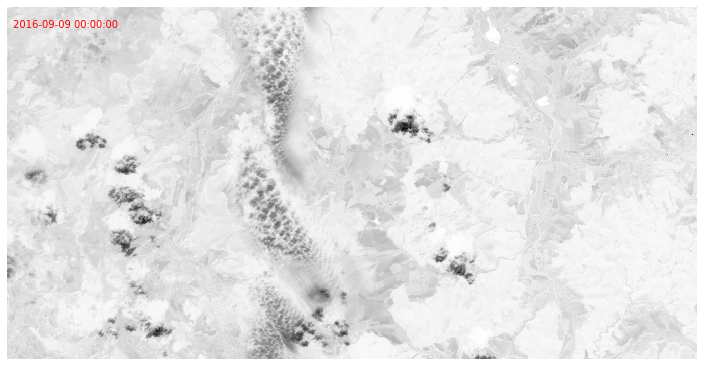

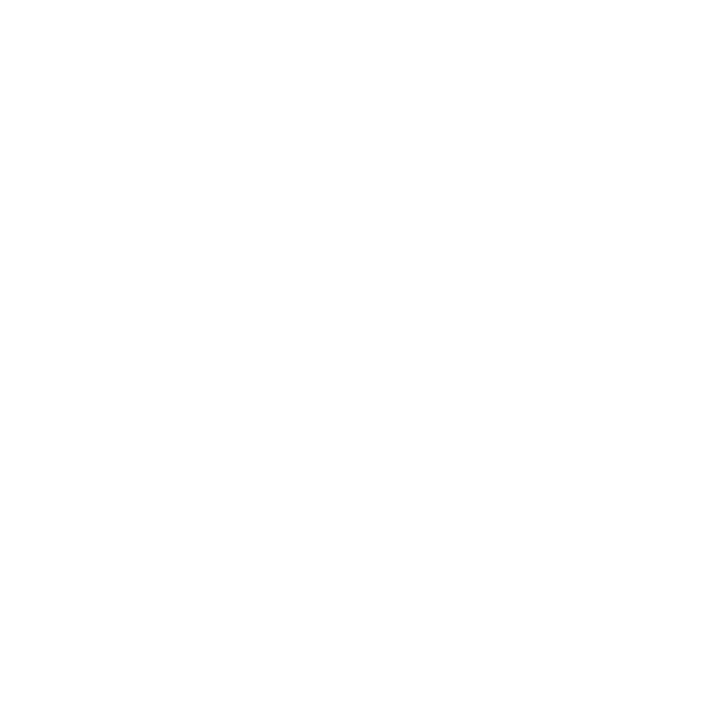

In [11]:
resolution = args.resolution
hour_diff = args.hour_diff
cloud_threshold = args.cloud_threshold
gif = args.gif
time_range =  args.time_range
n_procs = args.n_procs

#p = Pool(n_procs, maxtasksperchild=1)
#task = ThreadWithLogAndControls(target=load_eopatch, args=(p,), name="harvest EOPatches over AOI")
#task.control_panel()

for aoi_idx, bbox_splitter in enumerate(bbox_splitter_list):
    range_bbox = intersect_aoi(bbox_splitter, trainings[aoi_idx])
    range_idx = [bbox_splitter.bbox_list.index(bbox) for bbox in range_bbox]
    load_eopatch_multi = partial(load_eopatch, bbox_splitter, time_range, training_arrays[aoi_idx], 
                                 split_arrays[aoi_idx], training_vals[aoi_idx], f'{out_path}/{aoi_idx}')
    #multiprocess(n_procs, range_idx, load_eopatch_multi)
    for idx in range_idx:
        load_eopatch(bbox_splitter, time_range, training_arrays[aoi_idx], 
                                 split_arrays[aoi_idx], training_vals[aoi_idx], f'{out_path}/{aoi_idx}', idx)

# Print any produced output, whether eopatch extents, or gif produced.
# Probably best to read from filesystem saved outputs like the gif or the validity raster




# Interpolate the loaded EOPatches
Finding a new way of aggregating data instead of interpolation would be interesting for two reasons:
- Interpolation requires cloud masking, which would we have to work on to apply to LISS-III.
- Temporal data aggregation is much less computationally intensive than an interpolation.

The best way to go about this would be to:
- Define a temporal interval over which to aggregate.
- Determine the rule for pixel selection inside the temporal interval (max NDVI value for instance)
An article on temporal aggregation (with cloud cover): https://www.researchgate.net/publication/330814279_Evaluating_Combinations_of_Temporally_Aggregated_Sentinel-1_Sentinel-2_and_Landsat_8_for_Land_Cover_Mapping_with_Google_Earth_Engine
It would give you an idea of what temporal aggregation means at least. Note that a combination of metrics can be used (e.g. median of one index vs variance of another).


In [ ]:
# This implementation is an interpolation and not an aggregation, but we could consider switching that.

eopatch_sample = Path(str(f'{out_path}/lulc_sample/eopatch_{idx}'))
eopatch_nosample = Path(str(f'{out_path}/lulc_nosample/eopatch_{idx}'))
eopatch_sampled = Path(str(f'{out_path}/lulc_sampled/eopatch_{idx}'))

# TASK FOR CONCATENATION
# concatenate = ConcatenateData('FEATURES', ['BANDS', 'NDVI', 'NDWI', 'NORM'])
# Add additional collections if more than LIS-III is retrieved
concatenate = ConcatenateData('FEATURES', ['R2', 'P6'])

# TASK FOR FILTERING OUT TOO CLOUDY SCENES
# keep frames with > 80 % valid coverage
# valid_data_predicate = ValidDataFractionPredicate(0.8)
# filter_task = SimpleFilterTask((FeatureType.MASK, 'IS_VALID'), valid_data_predicate)
# valid_lulc_predicate = ValidLULCPredicate()
# filter_lulc = SimpleFilterTask((FeatureType.MASK_TIMELESS, 'LULC'), valid_lulc_predicate)

# TASK FOR LINEAR INTERPOLATION
# linear interpolation of full time-series and date resampling
linear_interp = LinearInterpolation(
    feature='FEATURES',  # name of field to interpolate
    mask_feature=(FeatureType.MASK, 'IS_VALID'),  # mask to be used in interpolation
    resample_range=resample_range,  # set the resampling range
    parallel=True  # Optimize CPU usage
)

# Task for performing morphological erosion of specific disk radius around land cover labels of choice
# erosion = ErosionTask((FeatureType.MASK_TIMELESS, 'LULC'), disk_radius=disk_radius)
erosion = ClassFilterTask((FeatureType.MASK_TIMELESS, 'LULC'), [1, 4, 6, 9], MorphologicalOperations.EROSION,
                          struct_elem=MorphologicalStructFactory.get_disk(disk_radius))

# Task for performing random sampling of land cover training labels
spatial_sampling = PointSamplingTask(
    n_samples=n_samples,
    ref_mask_feature='LULC',
    ref_labels=training_val,
    sample_features=[  # tag fields to sample
        (FeatureType.DATA, 'FEATURES',),
        (FeatureType.MASK, 'IS_VALID',),
        (FeatureType.MASK_TIMELESS, 'LULC',),
        (FeatureType.DATA_TIMELESS, 'SPLIT',)
    ],
    even_sampling=even_sampling)

# Task to save the resulting EOPatch to the disk
os.makedirs(f'{out_path}/lulc_sampled', exist_ok=True)
save = SaveToDisk(f'{out_path}/lulc_sampled',
                  overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

# Check to verify whether the current EOPatch contains training sample or not
if eopatch_sample.is_dir() and not Path(f'{eopatch_sampled}/data/FEATURES_SAMPLED.npy').is_file():
    print("this patch contains training samples. interpolating and sampling.")

    # Task to move the unaltered features from the old EOPatch to the new EOPatch
    move_features = MoveFeature({
        FeatureType.MASK_TIMELESS: {'LULC'},
        FeatureType.DATA_TIMELESS: {'SPLIT'},
        FeatureType.MASK: {'IS_VALID'}})

    # Declare locations where to load from/save to
    if save_choice:
        load = LoadFromDisk(f'{out_path}/lulc_sample', lazy_loading=True)
        save_dependency = [Dependency(task=save, inputs=[spatial_sampling])]
    else:
        load = LoadFromMemory()
        save_dependency = []

    # Declare workflow with the sequence of tasks
    workflow = EOWorkflow(dependencies=[
        Dependency(task=load, inputs=[]),
        Dependency(task=concatenate, inputs=[load]),
        # Dependency(task=filter_task, inputs=[concatenate]),
        # Dependency(task=filter_lulc, inputs=[concatenate]),
        Dependency(task=linear_interp, inputs=[concatenate]),
        # Dependency(task=move_features, inputs=[linear_interp,filter_task]),
        Dependency(task=move_features, inputs=[linear_interp, concatenate]),
        Dependency(task=erosion, inputs=[move_features]),
        Dependency(task=spatial_sampling, inputs=[move_features]),
        *save_dependency
    ])

elif not eopatch_sample.is_dir() and not eopatch_sampled.is_dir():
    print("this patch does not contain any training samples. interpolating without sampling.")

    # Task to move the unaltered features from the old EOPatch to the new EOPatch
    move_features = MoveFeature({
        FeatureType.MASK: {'IS_VALID'}})

    # Declare locations where to load from/save to
    if save_choice:
        load = LoadFromDisk(f'{out_path}/lulc_nosample', lazy_loading=True)
        save_dependency = [Dependency(task=save, inputs=[move_features])]
    else:
        load = LoadFromMemory()
        save_dependency = []

    # Declare workflow with the sequence of tasks
    workflow = EOWorkflow(dependencies=[
        Dependency(task=load, inputs=[]),
        Dependency(task=concatenate, inputs=[load]),
        # Dependency(task=filter_task, inputs=[concatenate]),
        # Dependency(task=filter_lulc, inputs=[concatenate]),
        Dependency(task=linear_interp, inputs=[concatenate]),
        # Dependency(task=move_features_ns, inputs=[linear_interp,filter_task]),
        Dependency(task=move_features, inputs=[linear_interp]),
        *save_dependency
    ])

# If the reduced EOPatch has already generated, return empty results
elif Path(f'{eopatch_sampled}/data/FEATURES_SAMPLED.npy').is_file():
    with open(f'{out_path}/lulc_sampled/range_sample.txt', "a") as f:
        f.write('%s\n' % idx)
    print("this patch has already been sampled. skipping to next patch.")
    return
else:
    print("this patch has already been interpolated (patch without samples). skipping to next patch.")
    return

# While loop necessary to re-perform workflow with different parameters.
# Cases are if a HTTPRequestError (simply retry) or MemoryError (not currently handled) is encountered.
attempts = 0
while attempts < 5:
    # Execute workflow
    try:
        if save_choice:
            result = workflow.execute({
                load: {'eopatch_folder': 'eopatch_{}'.format(idx)},
                save: {'eopatch_folder': 'eopatch_{}'.format(idx)}
            })
        else:
            result = workflow.execute({
                load: {'eopatch': eopatch}
            })

        print(result[list(result.keys())[-1]])
        patch_s2 = list(result.values())[-1]

        # Save the EOPatch index to file if it contains training data
        if patch_s2.mask_timeless['LULC_SAMPLED'].shape[0] == n_samples:
            with open(f'{out_path}/lulc_sampled/range_sample.txt', "a") as f:
                f.write('%s\n' % idx)
        # If not, remove the below EOPatch layers
        else:
            patch_s2.remove_feature(FeatureType.MASK_TIMELESS, 'LULC', )
            patch_s2.remove_feature(FeatureType.MASK_TIMELESS, 'LULC_SAMPLED', )
            patch_s2.remove_feature(FeatureType.DATA_TIMELESS, 'SPLIT', )
            patch_s2.remove_feature(FeatureType.DATA_TIMELESS, 'SPLIT_SAMPLED', )
            patch_s2.remove_feature(FeatureType.DATA, 'FEATURES_SAMPLED', )
            patch_s2.remove_feature(FeatureType.MASK, 'IS_VALID_SAMPLED', )

            if save_choice:
                patch_s2.save(f'{eopatch_sampled}',
                              overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

            # Clean up the folder structure of the EOPatch
            if os.path.exists(eopatch_sample):
                if not os.path.exists(eopatch_nosample):
                    os.mkdir(eopatch_nosample)
                for item in os.listdir(eopatch_sample):
                    s = os.path.join(eopatch_sample, item)
                    d = os.path.join(eopatch_nosample, item)
                    if os.path.isdir(s) and not os.path.exists(d):
                        shutil.copytree(s, d)
                    elif os.path.isfile(s) and not os.path.isfile(d):
                        shutil.copy2(s, d)
                shutil.rmtree(eopatch_sample)
        del result
    except MemoryError:
        # TODO: Find a good way to handle MemoryError rather than simply retrying
        # TODO: Add Jira Ticket
        print(f'Interpolation failed for eopatch {idx} due to a MemoryError, trying again')
        print("Exception in user code:")
        print('-'*60)
        traceback.print_exc(file=sys.stdout)
        print('-'*60)
        attempts += 1
        continue
    except OSError:
        # TODO: Find a good way to handle MemoryError rather than simply retrying
        # TODO: Add Jira Ticket
        print(f'Interpolation failed for eopatch {idx} due to an OSError, trying again')
        print("Exception in user code:")
        print('-'*60)
        traceback.print_exc(file=sys.stdout)
        print('-'*60)
        attempts += 1
        continue
    break


# Train a RF model for the respective AOIs
The implementation is a simple random forest ensemble, but if we have time we could investigate in the following:
- RNN or CNN using tensorflow (I don't really see it happening as we would need to recollect new training data).
- use SHAP ( https://github.com/slundberg/shap ) to perform a ML model explainability analysis. 
It doesn't directly help in getting the required outputs for the challenge, 
but would be interesting to understand correlation between input features and output.


In [ ]:
eopatches, range_sample = clean_training_data(range_sample, out_path)

range_sample, features_train, features_test, labels_train, labels_test, labels_unique, p1, t1, w1, h1, f1 = \
                                                                                            craft_input_features(
                                                                                            eopatches,
                                                                                            range_sample,
                                                                                            lulc_classes,
                                                                                            out_path)

# Set up the model
if model_path is not None:
    model = joblib.load(model_path)

model = lgb.LGBMClassifier(
    boosting_type='rf',
    objective='multiclass',
    num_class=len(labels_unique),
    metric='multi_logloss',
    bagging_freq=1,
    bagging_fraction=0.632,
    feature_fraction=0.632
    # class_weight={0:0.1,1:0.15,2:0.05,3:0.05,4:0.15,5:0.15,6:0.05,7:0.15,8:0.15}
    # n_jobs=8
)
# train the model
model.fit(features_train, labels_train)

start_date = time_interval[0]
end_date = time_interval[-1]
if not os.path.isdir(f'{out_path}/model'):
    os.makedirs(f'{out_path}/model', exist_ok=True)
joblib.dump(model, '{0}/model/{1}_{2}_{3}_{4}_{5}.pkl'
            .format(out_path, classifier, start_date, end_date,
                    interp_interval, datetime.datetime.now().strftime("%m.%d.%Y-%H:%M")))
joblib.dump(labels_unique, '{0}/model/labels_unique_{1}_{2}_{3}_{4}.pkl'
            .format(out_path, start_date, end_date,
                    interp_interval, datetime.datetime.now().strftime("%m.%d.%Y-%H:%M")))

# Plot test results and save them to ./test folder
#_test_model(model, eopatches, p1, t1, w1, h1, f1, features_test, labels_train, labels_test, lulc_classes, out_path)

# Perform a shap ML explainability analysis and save them to ./shap folder
#if shap:
#    shap_explainer(model, features_train, out_path)



# Plot test results


In [ ]:
# predict the test labels
plabels_test = model.predict(features_test)
plabels_test = plabels_test.reshape(plabels_test.shape[0], 1)

class_labels = [cl for cl in lulc_classes.values()]
class_names = [cn for cn in lulc_classes.keys()]

# Reference colormap things
lulc_cmap = mpl.colors.ListedColormap([entry.color for entry in LULC])

print('Classification accuracy {:.1f}%'.format(100 * metrics.accuracy_score(labels_test, plabels_test)))
print(
    'Classification F1-score {:.1f}%'.format(100 * metrics.f1_score(labels_test, plabels_test, average='weighted')))

f1_scores = metrics.f1_score(labels_test, plabels_test, labels=class_labels, average=None)
recall = metrics.recall_score(labels_test, plabels_test, labels=class_labels, average=None)
precision = metrics.precision_score(labels_test, plabels_test, labels=class_labels, average=None)

t = open(f'{out_path}/validation/test_confusion_matrix.txt', 'w+')
print('             Class              =  F1  | Recall | Precision')
t.write('             Class              =  F1  | Recall | Precision\n')
print('         --------------------------------------------------')
t.write('         --------------------------------------------------\n')
for idx, lulctype in zip(range(len(class_labels)), class_names):
    print('         * {0:20s} = {1:2.1f} |  {2:2.1f}  | {3:2.1f}'.format(lulctype,
                                                                         f1_scores[idx] * 100,
                                                                         recall[idx] * 100,
                                                                         precision[idx] * 100))
    t.write('         * {0:20s} = {1:2.1f} |  {2:2.1f}  | {3:2.1f}\n'.format(lulctype,
                                                                             f1_scores[idx] * 100,
                                                                             recall[idx] * 100,
                                                                             precision[idx] * 100))
t.close()


In [ ]:
# Confusion Matrix
fig1 = plt.figure(figsize=(20,20))

class_names_test = [class_names[label] for label in np.unique(labels_test)]

plt.subplot(1,2,1)
conf_matrix_gbm = metrics.confusion_matrix(labels_test, plabels_test)
plot_confusion_matrix(conf_matrix_gbm,
                      classes=class_names_test,
                      normalize=True,
                      ylabel='Truth (RABA)',
                      xlabel='Predicted (GBM)',
                      title='Confusion matrix')
plt.xticks(rotation=90)

plt.subplot(1,2,2)
conf_matrix_gbm = metrics.confusion_matrix(plabels_test, labels_test)
plot_confusion_matrix(conf_matrix_gbm,
                      classes=class_names_test,
                      normalize=True,
                      xlabel='Truth (RABA)',
                      ylabel='Predicted (GBM)',
                      title='Transposed Confusion matrix')
plt.xticks(rotation=90)
plt.tight_layout()

fig2 = plt.figure(figsize=(20,5))


In [ ]:
# Training Data Distribution Across Classes
label_ids, label_counts = np.unique(labels_train, return_counts=True)

plt.barh(range(len(label_ids)),label_counts)
plt.yticks(range(len(label_ids)), [class_names[i] for i in label_ids], fontsize=20)
plt.xticks(fontsize=20, rotation=45)
plt.title(f'Training Data Abundance Distribution across classes', fontsize=16, y=1.2)
plt.suptitle(f'Total sample size: {np.sum(label_counts)}',fontsize=14)

In [ ]:
# Plot ROC Curve

#Calculate precision and recall rates.
class_labels = np.unique(np.hstack([labels_test,labels_train]))
print(class_names)

scores_test = model.predict_proba(features_test)
labels_binarized = preprocessing.label_binarize(labels_test, classes=class_labels)
plot_colors = ['xkcd:darkgreen', 'xkcd:lime','xkcd:tan', 'orange','xkcd:beige','crimson','xkcd:azure', 'xkcd:lavender','xkcd:lightblue'] #'white','xkcd:lavender', 'black'

fpr = dict()
tpr = dict()
roc_auc = dict()

for idx,lbl in enumerate(class_labels):
    fpr[idx], tpr[idx], _ = metrics.roc_curve(labels_binarized[:, idx], scores_test[:, idx])
    roc_auc[idx] = metrics.auc(fpr[idx], tpr[idx])

plt.figure(figsize=(20,10))

absent_value = []
for idx,lbl in enumerate(class_labels):
    if np.isnan(roc_auc[idx]):
        continue
    try:
        plt.plot(fpr[idx], tpr[idx], color=plot_colors[idx],lw=2, label=class_names[lbl]+' (%0.5f)' % roc_auc[idx])
    except:
        absent_value.append(lbl)
        continue
        
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 0.2])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title(f'Receiver operating characteristic for {project_name}', fontsize=20)
plt.legend(loc="lower right", prop={'size':15})
plt.show()

In [ ]:
# Plot Feature Importance

# names of features
fnames = ['B2','B3','B4','B8','B11','B12','NDVI','NDWI','NORM']

# get feature importances and reshape them to dates and features
z = np.zeros(t1*f1)
z = model.feature_importances_
z = z.reshape((t1,f1))

fig3 = plt.figure(figsize=(20,18))
ax = plt.gca()

# plot the importances
im = ax.imshow(z,aspect=0.5)
plt.xticks(range(len(fnames)), fnames, rotation = 45, fontsize=20)
plt.yticks(range(t1), ['T{}'.format(i) for i in range(t1)], fontsize=20)

cax = fig3.add_axes([0.82, 0.125, 0.04, 0.755])
plt.colorbar(im, cax=cax)
plt.title(f'feature importance per date for {project_name}', fontsize=20, x=-7)
plt.show()

In [ ]:
# Plot most important band/date combination

z_max = unravel_index(np.argmax(z), z.shape)
print(z_max)
z_min = unravel_index(np.argmin(z[z>0]), z.shape)
print(z_min)

bsub_tsub = np.swapaxes(np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in eopatches[range_sample]]), 1, 3)[...,z_min[0],z_min[1]].reshape(p1*h1*w1)
bopt_tsub = np.swapaxes(np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in eopatches[range_sample]]), 1, 3)[...,z_max[0],z_min[1]].reshape(p1*h1*w1)
bsub_topt = np.swapaxes(np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in eopatches[range_sample]]), 1, 3)[...,z_min[0],z_max[1]].reshape(p1*h1*w1)
bopt_topt = np.swapaxes(np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in eopatches[range_sample]]), 1, 3)[...,z_max[0],z_max[1]].reshape(p1*h1*w1)
labels = np.array([eopatch.mask_timeless['LULC_SAMPLED'] for eopatch in eopatches[range_sample]]).reshape(p1*h1*w1*1)

# remove nans
mask = np.any([np.isnan(bsub_tsub), np.isnan(bopt_tsub), np.isnan(bsub_topt), np.isnan(bopt_topt), labels==0],axis=0)
bsub_tsub, bopt_tsub, bsub_topt, bopt_topt, labels = [array[~mask] for array in [bsub_tsub, bopt_tsub, bsub_topt, bopt_topt, labels]]

fig4 = plt.figure(figsize=(20,20))

plot_labels = np.unique(labels)
plot_colors = lulc_cmap.colors
plot_colors = ['xkcd:darkgreen', 'xkcd:lime','xkcd:tan', 'orange','xkcd:beige','crimson','xkcd:azure', 'xkcd:lavender','xkcd:lightblue'] #'white','xkcd:lavender', 'black'
print(plot_labels)
print(plot_colors)

plt.subplot(2,2,1)
plt.hist([bsub_topt[labels == i] for i in plot_labels],100,(-0.4, 0.8),histtype='step',
         color=[plot_colors[i] for i in range(len(plot_labels))],
         label=[class_names[i] for i in plot_labels],
         )
plt.title(f'Most important band at least optimal date T{z_min[0]}', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(f'{fnames[z_max[1]]}', fontsize=20)
plt.legend(loc=1, prop={'size':15})

plt.subplot(2,2,2)
plt.hist([bopt_topt[labels == i] for i in plot_labels],100,(-0.4, 0.8),histtype='step',
         color=[plot_colors[i] for i in range(len(plot_labels))],
         )
plt.title(f'Most important band at most optimal date T{z_max[0]}', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(f'{fnames[z_max[1]]}', fontsize=20)

plt.subplot(2,2,3)
plt.title(f'Least important band at least optimal date T{z_min[0]}', fontsize=20)
plt.hist([bsub_tsub[labels == i] for i in plot_labels],100,(0.1, 0.7),histtype='step',
         color=[plot_colors[i] for i in range(len(plot_labels))],
         )
plt.xticks(fontsize=20)#     plt.yticks(fontsize=20)
plt.xlabel(f'{fnames[z_min[1]]}', fontsize=20)

plt.subplot(2,2,4)
plt.title(f'Least important band at most optimal date T{z_max[0]}', fontsize=20)
plt.hist([bopt_tsub[labels == i] for i in plot_labels],100,(0.1, 0.7),histtype='step',
         color=[plot_colors[i] for i in range(len(plot_labels))],
         )
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(f'{fnames[z_min[1]]}', fontsize=20)
plt.show()

pbar = tqdm(total=len(bbox_splitter.bbox_list))



# Predict EOPatches using trained model


In [ ]:
info = bbox_splitter.info_list[idx]

os.makedirs(f'{out_path}/lulc_pred', exist_ok=True)

tiff_pred = f'pred_eopatch_{idx}_row-{info["index_x"]}_col-{info["index_y"]}.tiff'
pred_output = PredictPatch(model, len(labels_unique), proba, shap)
export_pred = ExportToTiff((FeatureType.DATA_TIMELESS, 'PRED'),
                           image_dtype=np.uint8, no_data_value=0, date_indices=[0], band_indices=[0])

if not os.path.isdir(f'{out_path}/logs'):
    os.makedirs(f'{out_path}/logs')

range_missing = open(f'{out_path}/logs/missing_eopatches.txt', 'w+')
if os.path.isdir(f'{out_path}/lulc_sampled/eopatch_{idx}'):
    load = LoadFromDisk(f'{out_path}/lulc_sampled')
    save = SaveToDisk(f'{out_path}/lulc_sampled',
                      overwrite_permission=OverwritePermission.OVERWRITE_PATCH)
else:
    # TODO: How to send these EOPatches to the back of the job queue for reprocessing?
    print(f'EOPatch {idx} is missing! Logging it for reprocessing...')
    range_missing.write(f'{idx}\n')
    return

if proba is True:
    export_proba = ExportToTiff((FeatureType.DATA_TIMELESS, 'PRED_PROBA'),
                                image_dtype=np.float32, band_indices=(0, 8), no_data_value=0, date_indices=[0])
    workflow_pred = LinearWorkflow(load,
                                   pred_output,
                                   save,
                                   export_pred,
                                   export_proba
                                   )

    tiff_proba = f'proba_eopatch_{idx}_row-{info["index_x"]}_col-{info["index_y"]}.tiff'
    extra_param[export_proba] = {'filename': f'{out_path}/lulc_pred/{tiff_proba}'}
else:
    workflow_pred = LinearWorkflow(load,
                                   pred_output,
                                   save,
                                   export_pred
                                   )

if os.path.isfile(f'{out_path}/lulc_pred/{tiff_pred}'):
    print("this patch has already been predicted. skipping to next patch.")
    return
else:
    attempts = 0
    while attempts < 5:
        try:
            result_pred = workflow_pred.execute(
                {load: {'eopatch_folder': f'eopatch_{idx}'},
                 save: {'eopatch_folder': f'eopatch_{idx}'},
                 export_pred: {'filename': f'{out_path}/lulc_pred/{tiff_pred}'}
                 })
            print(result_pred[list(result_pred.keys())[-1]])
            patch_s2 = list(result_pred.values())[-1]
        except:
            print(f'Prediction for eopatch {idx} has failed, trying again...')
            print("Exception in user code:")
            print('-' * 60)
            traceback.print_exc(file=sys.stdout)
            print('-' * 60)
            attempts += 1
            continue
        break


# Plot a web map 
Some examples of implementation using ipywidget and ipyleaflet. 


In [ ]:
# Color mapping of the land cover classes to display.
newcolors = np.zeros((12,4))
newcolors[0,:] = np.asarray([0,0,0,0])
newcolors[1,:] = np.asarray([183, 219, 177, 255])
newcolors[2,:] = np.asarray([0,0,0,0])
newcolors[3,:] = np.asarray([149, 224, 145, 255])
newcolors[4,:] = np.asarray([255, 223, 145, 255])
newcolors[5,:] = np.asarray([0,0,0,0])
newcolors[6,:] = np.asarray([226, 193, 115, 255])
newcolors[7,:] = np.asarray([255, 244, 150, 255])
newcolors[8,:] = np.asarray([255, 150, 150, 255])
newcolors[9,:] = np.asarray([150, 171, 255, 255])
newcolors[10,:] = np.asarray([209, 183, 255, 255])
newcolors[11,:] = np.asarray([183, 255, 253, 255])

print(newcolors/255)
newcmp = ListedColormap(newcolors/255)
print(newcmp)


In [ ]:
# Create a map using Stamen Terrain, centered on study area with set zoom level
m = Map(center=(37, -120), zoom=0, basemap=basemaps.Stamen.Toner)
m


In [ ]:
sc = Sidecar(title='California Map')
with sc:
    display(m)

In [ ]:
 # Iteratively display the predicted tiles as they become available in folder structure
    for tiff in glob.glob("/mnt/1t-drive/eopatch-L1C/nam_usa_uca/lulc_pred/val_pred_sh_eopatch_*local.tiff"):
    out_path = "/mnt/1t-drive/eopatch-L1C/nam_usa_uca/lulc_pred/folium/"+tiff[:-5].split('/')[-1]+"_4326.tiff"
    with rio.open(out_path) as src:
        boundary = src.bounds
    
    m.add_layer(ImageOverlay(url="http://172.29.254.183:8000/"+tiff[:-5].split('/')[-1]+"_4326.png", bounds=((boundary[1], boundary[0]), 
                                             (boundary[3], boundary[2])), opacity=1))
    m

In [ ]:
#Add a local tile server
os.chdir("/mnt/1t-drive/eopatch-L1C/nam_usa_uca/lulc_pred/")
m.add_layer(TileLayer(url="http://172.29.254.183:8000/{z}/{x}/{y}.png"))
m

In [ ]:
for tiff in glob.glob("/mnt/1t-drive/eopatch-L1C/nam_usa_uca/lulc_pred/val_pred_sh_eopatch_*local.tiff"):
    # Create variables for destination coordinate system and the name of the projected raster
    src_crs = 'EPSG:32719' 
    dst_crs = 'EPSG:4326' 
    out_vrt = "/mnt/1t-drive/eopatch-L1C/nam_usa_uca/lulc_pred/folium/"+tiff[:-5].split('/')[-1]+"_col1.tiff"
    out_vrt1 = "/mnt/1t-drive/eopatch-L1C/nam_usa_uca/lulc_pred/folium/"+tiff[:-5].split('/')[-1]+"_col.tiff"
    out_path = "/mnt/1t-drive/eopatch-L1C/nam_usa_uca/lulc_pred/folium/"+tiff[:-5].split('/')[-1]+"_4326.tiff"
    out_jpg = "/mnt/1t-drive/eopatch-L1C/nam_usa_uca/lulc_pred/folium/"+tiff[:-5].split('/')[-1]+"_4326.png"
    out_tms = "/mnt/1t-drive/eopatch-L1C/nam_usa_uca/lulc_pred/folium/"+tiff[:-5].split('/')[-1]+"_4326"
    #print(out_path)
    
    cmd = 'gdaldem color-relief %s /mnt/1t-drive/eopatch-L1C/nam_usa_uca/lulc_pred/col.txt %s -of Gtiff'%(tiff,out_vrt)
    !{cmd}
    """cmd1 = 'gdalwarp -of GTiff -overwrite -s_srs %s -t_srs %s %s %s'%(src_crs, dst_crs, out_vrt, out_vrt1)
    !{cmd1}
    os.remove(out_vrt)
    cmd2 = 'gdal_translate -of JPEG %s %s'%(out_vrt1,out_path)
    !{cmd2}"""
    
    #subprocess.call(["gdaldem","color-relief", tiff, "/mnt/1t-drive/eopatch-L1C/nam_usa_uca/lulc_pred/col.txt",out_vrt,"-of" ,"VRT"])
    #subprocess.call(["gdalwarp","-of", "JPEG", "-s_srs",src_crs,"-t_srs",dst_crs, out_vrt, out_path])
    
    # Use rasterio package as rio to open and project the raster
    with rio.open(out_vrt) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        # Use rasterio package as rio to write out the new projected raster
        # Code uses loop to account for multi-band rasters
        with rio.open(out_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                source=rio.band(src, i),
                destination=rio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
    # Use rasterio to import the reprojected data as img
    with rio.open(out_path) as src:
        boundary = src.bounds
        #print(boundary)
        #img = src.read()
        #nodata = src.nodata
    
    cmd2 = "convert %s -transparent black -fuzz 11%% %s"%(out_path, out_jpg)
    !{cmd2}

    # Overlay raster called img using add_child() function (opacity and bounding box set)
    #m.add_child( folium.raster_layers.ImageOverlay(img[0], opacity=1, colormap=newcmp,
    #                                 bounds =[[boundary[1], boundary[0]], [boundary[3], boundary[2]]]))
    m.add_layer(ImageOverlay(url="http://172.29.254.183:8000/"+tiff[:-5].split('/')[-1]+"_4326.png", bounds=((boundary[1], boundary[0]), 
                                             (boundary[3], boundary[2])), opacity=1))

    m
    
m.save(outfile= "/mnt/1t-drive/eopatch-L1C/nam_usa_uca/lulc_pred/folium/test.html")
